In [1]:
# connect to drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
root_path = '/content/drive/Shareddrives/CV_Action_Recognition_Project/Dataset/'

In [ ]:
# Paths

main_folder = "/content/drive/Shareddrives/CV_Action_Recognition_Project/"
data_path = main_folder + 'Dataset'
model_path = main_folder + 'Model'

In [3]:
import numpy as np

with open("/content/drive/Shareddrives/CV_Action_Recognition_Project/Dataset/UCF/npy_files/" + "raw_crops_rgb_and_flow.npy", 'rb') as f:
    data_one_crop = np.load(f, allow_pickle=True)
    data_two_crop = np.load(f, allow_pickle=True)
    flow_one_crop = np.load(f, allow_pickle=True)
    flow_two_crop = np.load(f, allow_pickle=True)
    label = np.load(f, allow_pickle=True)


In [4]:
data_one_crop.shape

(140, 8, 224, 224, 3)

In [5]:
data_two_crop.shape

(140, 8, 2, 224, 224, 3)

In [ ]:
data_one_crop

In [6]:
data_one_crop = data_one_crop/255
data_two_crop = data_two_crop/255
flow_one_crop = flow_one_crop/255
flow_two_crop = flow_two_crop/255

In [7]:
data_one_crop = np.transpose(data_one_crop, (0, 1, 4, 2, 3))
data_two_crop = np.transpose(data_two_crop, (0, 2, 1, 5, 3, 4))
flow_one_crop = np.transpose(flow_one_crop, (0, 1, 4, 2, 3))
flow_two_crop = np.transpose(flow_two_crop, (0, 2, 1, 5, 3, 4))

In [11]:
data_one_crop.shape

(140, 8, 3, 224, 224)

In [12]:
data_two_crop.shape

(140, 2, 8, 3, 224, 224)

Models 

TimeSformer

Swin Transformer

R2plus1D

# TimeSformer

In [13]:
!git clone https://github.com/wanchichen/TimeSformer

Cloning into 'TimeSformer'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 421 (delta 122), reused 92 (delta 92), pack-reused 248
Receiving objects: 100% (421/421), 338.99 KiB | 5.56 MiB/s, done.
Resolving deltas: 100% (199/199), done.


In [14]:
import sys
sys.path.insert(0,'/content/TimeSformer')

In [15]:
!pip install einops
!pip install 'git+https://github.com/facebookresearch/fvcore'
!pip install simplejson
!pip install timm
!pip install psutil
!pip install tensorboard


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/fvcore to /tmp/pip-req-build-17mvtpaj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore /tmp/pip-req-build-17mvtpaj
  Resolved https://github.com/facebookresearch/fvcore to commit 51092b5515cbb493f73de079743dd6b11cc4bbf1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65405 sha256=5eca6169db197079b676db258ad3446ade535c1123e88d38a547e498b51b2612
  Stored in directory: /tmp/pip-ephem-wheel-cache-o7o4tts9/wheels/a6/fe/66/6e6bfe16b94f13bf3e15

In [31]:
from torch.utils.data import Dataset
class LocalDataset(Dataset):
    def __init__(self, data, label, transform=None, target_transform=None):
        self.data = data
        self.label = label
        self.transform = transform
        self.target_transform = target_transform 
    def __len__(self):
        return len(self.label)
    def __getitem__(self, idx):
        X = torch.FloatTensor(self.data[idx])
        Y = torch.tensor(self.label[idx])
        
        if self.transform:
          X = np.transpose(X, (1, 0, 2, 3))

          X = self.transform(X)

          #X = np.transpose(X, (1, 0, 2, 3))
        if self.target_transform:
            Y = self.target_transform(Y)
        return X, Y

In [32]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import nn

batch_size = 50

augment = False
# augmentation and normalizations
if augment:
  transform_train = transforms.Compose([
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(10),
                                        transforms.RandomCrop([224, 224], padding = 10),
                                        #transforms.ColorJitter(brightness = 0.25, contrast= 0.25, saturation=0.25, hue=0.25),
                                        #transforms.ToTensor()
                                        #, transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
                                                            ])
else:
  transform_train = transforms.Compose([
                                      #transforms.RandomHorizontalFlip(),
                                      #transforms.RandomRotation(10),
                                      #transforms.RandomCrop([224, 224], padding = 10),
                                      #transforms.ColorJitter(brightness = 0.25, contrast= 0.25, saturation=0.25, hue=0.25),
                                      #transforms.ToTensor()
                                      #, transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
                                                          ])

transform_test = transforms.Compose(
    [])


one_crop_dataset = LocalDataset(data_one_crop, label, transform = transform_train)
upper_crop_dataset = LocalDataset(data_two_crop[:, 0], label, transform = transform_train)
lower_crop_dataset = LocalDataset(data_two_crop[:, 1], label, transform = transform_train)
one_flow_dataset = LocalDataset(flow_one_crop, label, transform = transform_train)
upper_flow_dataset = LocalDataset(flow_two_crop[:, 0], label, transform = transform_train)
lower_flow_dataset = LocalDataset(flow_two_crop[:, 1], label, transform = transform_train)


one_crop_dataloader = DataLoader(one_crop_dataset, batch_size=batch_size, shuffle=False)
upper_crop_dataloader = DataLoader(upper_crop_dataset, batch_size=batch_size, shuffle=False)
lower_crop_dataloader = DataLoader(lower_crop_dataset, batch_size=batch_size, shuffle=False)
one_flow_dataloader = DataLoader(one_flow_dataset, batch_size=batch_size, shuffle=False)
upper_flow_dataloader = DataLoader(upper_flow_dataset, batch_size=batch_size, shuffle=False)
lower_flow_dataloader = DataLoader(lower_flow_dataset, batch_size=batch_size, shuffle=False)


# Create data loaders for training data
print("\nTraining data: ")
for X, y in one_crop_dataloader:
    print("\nShape of X per batch: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

print("\nTest data: ")
for X, y in upper_flow_dataloader:
    print("\nShape of X per batch: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

print("\nAll data loaded.")


Training data: 

Shape of X per batch:  torch.Size([50, 3, 8, 224, 224])
Shape of y:  torch.Size([50]) torch.int64

Test data: 

Shape of X per batch:  torch.Size([50, 3, 8, 224, 224])
Shape of y:  torch.Size([50]) torch.int64

All data loaded.


In [27]:
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

def extract_data(net, dataloader, epoch_num = 1):
    
    net.to(device)
    net.eval()

    extracted_data = []
    labels_list = []

    print("\n---------------------Extraction Starts---------------------\n")
    for epoch in range(epoch_num):  # loop over the dataset multiple times

        running_loss = 0.0
        total_epoch = 0
        correct_epoch = 0
        count_batch = 0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to (device)
            outputs = net(inputs)

            outputs = outputs.to ("cpu")
            extracted_data.extend(outputs.numpy())
            labels_list.extend(labels.numpy())
            print("*", end="")

   

        print('\nEpoch[%d] ' %
                  (epoch + 1))

  
    print("\n---------------------Finished---------------------\n")

    return extracted_data, labels_list

Using cuda device


In [23]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

import torch.optim as optim
import torch
from timesformer.models.vit import TimeSformer

net = TimeSformer(img_size = 224, num_classes=13, num_frames=8, attention_type='divided_space_time',  pretrained_model= '/content/drive/Shareddrives/HAR/TimeSformer_divST_8x32_224_K400.pyth')
net.model.head = Identity()

for name, param in net.named_parameters():
  param.requires_grad = False

In [24]:

print(net)

TimeSformer(
  (model): VisionTransformer(
    (dropout): Dropout(p=0.0, inplace=False)
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (time_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
        )
        (temporal_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (temporal_attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
   

In [33]:
import torch.optim as optim
import torch
from timesformer.models.vit import TimeSformer

net.to(device)

data_oc, label = extract_data(net = net,
                     dataloader = one_crop_dataloader, epoch_num = 1)
data_uc, label = extract_data(net = net,
                     dataloader = upper_crop_dataloader, epoch_num = 1)
data_lc, label = extract_data(net = net,
                     dataloader = lower_crop_dataloader, epoch_num = 1)
data_of, label = extract_data(net = net,
                     dataloader = one_flow_dataloader, epoch_num = 1)
data_uf, label = extract_data(net = net,
                     dataloader = upper_flow_dataloader, epoch_num = 1)
data_lf, label = extract_data(net = net,
                     dataloader = lower_flow_dataloader, epoch_num = 1)



---------------------Extraction Starts---------------------

***
Epoch[1] 

---------------------Finished---------------------



In [39]:
data_oc = np.array(data_oc)
data_uc = np.array(data_uc)
data_lc = np.array(data_lc)
data_of = np.array(data_of)
data_uf = np.array(data_uf)
data_lf = np.array(data_lf)

In [35]:
np.array(data).shape

(140, 768)

In [40]:
print(data_oc.shape)
print(data_uc.shape)
print(data_lc.shape)
print(data_of.shape)
print(data_uf.shape)
print(data_lf.shape)

(140, 768)
(140, 768)
(140, 768)
(140, 768)
(140, 768)
(140, 768)


In [41]:
# DO NOT RUN THE FOLLOWING CODE, UNLESS YOU KNOW WHAT YOU ARE DOING

run_save = True
if run_save:
  with open("/content/drive/Shareddrives/CV_Action_Recognition_Project/Dataset/UCF/npy_files/" + "TimeSformer_rgb_and_flow.npy", 'wb') as f:
      np.save(f, data_oc)
      np.save(f, data_uc)
      np.save(f, data_lc)
      np.save(f, data_of)
      np.save(f, data_uf)
      np.save(f, data_lf)
      np.save(f, label)


In [66]:
import numpy as np

with open("/content/drive/Shareddrives/CV_Action_Recognition_Project/Dataset/UCF/npy_files/" + "TimeSformer_rgb_and_flow.npy", 'rb') as f:
    data_oc = np.load(f, allow_pickle=True)
    data_uc = np.load(f, allow_pickle=True)
    data_lc = np.load(f, allow_pickle=True)
    data_of = np.load(f, allow_pickle=True)
    data_uf = np.load(f, allow_pickle=True)
    data_lf = np.load(f, allow_pickle=True)
    label = np.load(f, allow_pickle=True)


In [67]:
label

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
        1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12])

In [44]:
import matplotlib.pyplot as plt

def show_images(images):
    n: int = len(images)
    f = plt.figure(figsize=(20,7))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i])

    plt.show(block=True)

images = flow_one_crop[0]
print(images.shape)

images_t = torch.from_numpy(images)

images = np.transpose(images, (0, 2, 3, 1))


(8, 3, 224, 224)


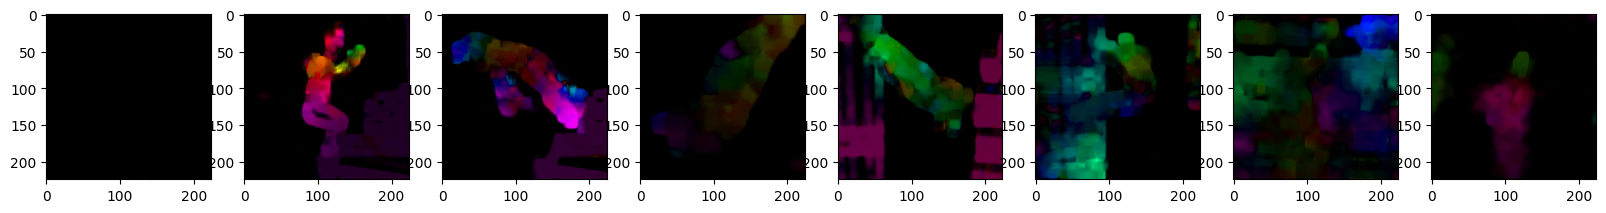

In [45]:
show_images(images)

In [57]:
del net

In [59]:
del net
del model

import gc
gc.collect() 
torch.cuda.empty_cache()

# CNN

In [53]:
from torchvision.io.video import read_video
from torchvision.models.video import r3d_18, R3D_18_Weights

vid = flow_one_crop[0]
vid = torch.from_numpy(vid)
# Step 1: Initialize model with the best available weights
weights = R3D_18_Weights.DEFAULT
model = r3d_18(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
#preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
#batch = preprocess(vid).unsqueeze(0)

# Step 4: Use the model and print the predicted category
#prediction = model(batch).squeeze(0).softmax(0)
##label = prediction.argmax().item()
#score = prediction[label].item()
#category_name = weights.meta["categories"][label]
#print(f"{category_name}: {100 * score}%")

pumping fist: 29.494360089302063%


In [55]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

import torch.optim as optim
import torch

model.fc = Identity()

for name, param in model.named_parameters():
  param.requires_grad = False

In [56]:
print(model)

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [64]:
label

256

In [68]:
from torch.utils.data import Dataset
class LocalDataset(Dataset):
    def __init__(self, data, label, transform=None, target_transform=None):
        self.data = data
        self.label = label
        self.transform = transform
        self.target_transform = target_transform 
    def __len__(self):
        return len(self.label)
    def __getitem__(self, idx):
        X = torch.FloatTensor(self.data[idx])
        Y = torch.tensor(self.label[idx])
        
        if self.transform:

          X = self.transform(X)

          #X = np.transpose(X, (1, 0, 2, 3))
        if self.target_transform:
            Y = self.target_transform(Y)
        return X, Y

In [69]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import nn

batch_size = 50

transform_train = preprocess

one_crop_dataset = LocalDataset(data_one_crop, label, transform = transform_train)
upper_crop_dataset = LocalDataset(data_two_crop[:, 0], label, transform = transform_train)
lower_crop_dataset = LocalDataset(data_two_crop[:, 1], label, transform = transform_train)
one_flow_dataset = LocalDataset(flow_one_crop, label, transform = transform_train)
upper_flow_dataset = LocalDataset(flow_two_crop[:, 0], label, transform = transform_train)
lower_flow_dataset = LocalDataset(flow_two_crop[:, 1], label, transform = transform_train)

one_crop_dataloader = DataLoader(one_crop_dataset, batch_size=batch_size, shuffle=False)
upper_crop_dataloader = DataLoader(upper_crop_dataset, batch_size=batch_size, shuffle=False)
lower_crop_dataloader = DataLoader(lower_crop_dataset, batch_size=batch_size, shuffle=False)
one_flow_dataloader = DataLoader(one_flow_dataset, batch_size=batch_size, shuffle=False)
upper_flow_dataloader = DataLoader(upper_flow_dataset, batch_size=batch_size, shuffle=False)
lower_flow_dataloader = DataLoader(lower_flow_dataset, batch_size=batch_size, shuffle=False)


# Create data loaders for training data
print("\nTraining data: ")
for X, y in one_crop_dataloader:
    print("\nShape of X per batch: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

print("\nTest data: ")
for X, y in upper_flow_dataloader:
    print("\nShape of X per batch: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

print("\nAll data loaded.")


Training data: 

Shape of X per batch:  torch.Size([50, 3, 8, 112, 112])
Shape of y:  torch.Size([50]) torch.int64

Test data: 

Shape of X per batch:  torch.Size([50, 3, 8, 112, 112])
Shape of y:  torch.Size([50]) torch.int64

All data loaded.


In [71]:
import torch.optim as optim
import torch
net = model
net.to(device)

data_oc, label = extract_data(net = net,
                     dataloader = one_crop_dataloader, epoch_num = 1)
data_uc, label = extract_data(net = net,
                     dataloader = upper_crop_dataloader, epoch_num = 1)
data_lc, label = extract_data(net = net,
                     dataloader = lower_crop_dataloader, epoch_num = 1)
data_of, label = extract_data(net = net,
                     dataloader = one_flow_dataloader, epoch_num = 1)
data_uf, label = extract_data(net = net,
                     dataloader = upper_flow_dataloader, epoch_num = 1)
data_lf, label = extract_data(net = net,
                     dataloader = lower_flow_dataloader, epoch_num = 1)



---------------------Extraction Starts---------------------

***
Epoch[1] 

---------------------Finished---------------------


---------------------Extraction Starts---------------------

***
Epoch[1] 

---------------------Finished---------------------


---------------------Extraction Starts---------------------

***
Epoch[1] 

---------------------Finished---------------------


---------------------Extraction Starts---------------------

***
Epoch[1] 

---------------------Finished---------------------


---------------------Extraction Starts---------------------

***
Epoch[1] 

---------------------Finished---------------------


---------------------Extraction Starts---------------------

***
Epoch[1] 

---------------------Finished---------------------



In [72]:
data_oc = np.array(data_oc)
data_uc = np.array(data_uc)
data_lc = np.array(data_lc)
data_of = np.array(data_of)
data_uf = np.array(data_uf)
data_lf = np.array(data_lf)

In [73]:
print(data_oc.shape)
print(data_uc.shape)
print(data_lc.shape)
print(data_of.shape)
print(data_uf.shape)
print(data_lf.shape)

(140, 512)
(140, 512)
(140, 512)
(140, 512)
(140, 512)
(140, 512)


In [74]:
# DO NOT RUN THE FOLLOWING CODE, UNLESS YOU KNOW WHAT YOU ARE DOING

run_save = True
if run_save:
  with open("/content/drive/Shareddrives/CV_Action_Recognition_Project/Dataset/UCF/npy_files/" + "R3D_18_rgb_and_flow.npy", 'wb') as f:
      np.save(f, data_oc)
      np.save(f, data_uc)
      np.save(f, data_lc)
      np.save(f, data_of)
      np.save(f, data_uf)
      np.save(f, data_lf)
      np.save(f, label)


In [ ]:
import numpy as np

with open("/content/drive/Shareddrives/CV_Action_Recognition_Project/Dataset/UCF/npy_files/" + "R3D_18_rgb_and_flow.npy", 'rb') as f:
    data_oc = np.load(f, allow_pickle=True)
    data_uc = np.load(f, allow_pickle=True)
    data_lc = np.load(f, allow_pickle=True)
    data_of = np.load(f, allow_pickle=True)
    data_uf = np.load(f, allow_pickle=True)
    data_lf = np.load(f, allow_pickle=True)
    label = np.load(f, allow_pickle=True)


In [75]:
del net
del model

import gc
gc.collect() 
torch.cuda.empty_cache()

# Swin Transformer

In [79]:
from torchvision.io.video import read_video
from torchvision.models.video import swin3d_t, Swin3D_T_Weights

vid = flow_one_crop[0]
vid = torch.from_numpy(vid)
# Step 1: Initialize model with the best available weights
weights = Swin3D_T_Weights.DEFAULT
model = swin3d_t(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(vid).unsqueeze(0)

# Step 4: Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
label_1 = prediction.argmax().item()
score = prediction[label_1].item()
category_name = weights.meta["categories"][label_1]
print(f"{category_name}: {100 * score}%")

pumping fist: 55.18897771835327%


In [80]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

import torch.optim as optim
import torch

model.head = Identity()

for name, param in model.named_parameters():
  param.requires_grad = False

In [81]:
print(model)

SwinTransformer3d(
  (patch_embed): PatchEmbed3d(
    (proj): Conv3d(3, 96, kernel_size=(2, 4, 4), stride=(2, 4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (features): Sequential(
    (0): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention3d(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
     

In [82]:
from torch.utils.data import Dataset
class LocalDataset(Dataset):
    def __init__(self, data, label, transform=None, target_transform=None):
        self.data = data
        self.label = label
        self.transform = transform
        self.target_transform = target_transform 
    def __len__(self):
        return len(self.label)
    def __getitem__(self, idx):
        X = torch.FloatTensor(self.data[idx])
        Y = torch.tensor(self.label[idx])
        
        if self.transform:

          X = self.transform(X)

          #X = np.transpose(X, (1, 0, 2, 3))
        if self.target_transform:
            Y = self.target_transform(Y)
        return X, Y

In [83]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import nn

batch_size = 50

transform_train = preprocess

one_crop_dataset = LocalDataset(data_one_crop, label, transform = transform_train)
upper_crop_dataset = LocalDataset(data_two_crop[:, 0], label, transform = transform_train)
lower_crop_dataset = LocalDataset(data_two_crop[:, 1], label, transform = transform_train)
one_flow_dataset = LocalDataset(flow_one_crop, label, transform = transform_train)
upper_flow_dataset = LocalDataset(flow_two_crop[:, 0], label, transform = transform_train)
lower_flow_dataset = LocalDataset(flow_two_crop[:, 1], label, transform = transform_train)

one_crop_dataloader = DataLoader(one_crop_dataset, batch_size=batch_size, shuffle=False)
upper_crop_dataloader = DataLoader(upper_crop_dataset, batch_size=batch_size, shuffle=False)
lower_crop_dataloader = DataLoader(lower_crop_dataset, batch_size=batch_size, shuffle=False)
one_flow_dataloader = DataLoader(one_flow_dataset, batch_size=batch_size, shuffle=False)
upper_flow_dataloader = DataLoader(upper_flow_dataset, batch_size=batch_size, shuffle=False)
lower_flow_dataloader = DataLoader(lower_flow_dataset, batch_size=batch_size, shuffle=False)


# Create data loaders for training data
print("\nTraining data: ")
for X, y in one_crop_dataloader:
    print("\nShape of X per batch: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

print("\nTest data: ")
for X, y in upper_flow_dataloader:
    print("\nShape of X per batch: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

print("\nAll data loaded.")


Training data: 

Shape of X per batch:  torch.Size([50, 3, 8, 224, 224])
Shape of y:  torch.Size([50]) torch.int64

Test data: 

Shape of X per batch:  torch.Size([50, 3, 8, 224, 224])
Shape of y:  torch.Size([50]) torch.int64

All data loaded.


In [84]:
import torch.optim as optim
import torch
net = model
net.to(device)

data_oc, label = extract_data(net = net,
                     dataloader = one_crop_dataloader, epoch_num = 1)
data_uc, label = extract_data(net = net,
                     dataloader = upper_crop_dataloader, epoch_num = 1)
data_lc, label = extract_data(net = net,
                     dataloader = lower_crop_dataloader, epoch_num = 1)
data_of, label = extract_data(net = net,
                     dataloader = one_flow_dataloader, epoch_num = 1)
data_uf, label = extract_data(net = net,
                     dataloader = upper_flow_dataloader, epoch_num = 1)
data_lf, label = extract_data(net = net,
                     dataloader = lower_flow_dataloader, epoch_num = 1)



---------------------Extraction Starts---------------------

***
Epoch[1] 

---------------------Finished---------------------


---------------------Extraction Starts---------------------

***
Epoch[1] 

---------------------Finished---------------------


---------------------Extraction Starts---------------------

***
Epoch[1] 

---------------------Finished---------------------


---------------------Extraction Starts---------------------

***
Epoch[1] 

---------------------Finished---------------------


---------------------Extraction Starts---------------------

***
Epoch[1] 

---------------------Finished---------------------


---------------------Extraction Starts---------------------

***
Epoch[1] 

---------------------Finished---------------------



In [85]:
data_oc = np.array(data_oc)
data_uc = np.array(data_uc)
data_lc = np.array(data_lc)
data_of = np.array(data_of)
data_uf = np.array(data_uf)
data_lf = np.array(data_lf)

print(data_oc.shape)
print(data_uc.shape)
print(data_lc.shape)
print(data_of.shape)
print(data_uf.shape)
print(data_lf.shape)

(140, 768)
(140, 768)
(140, 768)
(140, 768)
(140, 768)
(140, 768)


In [86]:
# DO NOT RUN THE FOLLOWING CODE, UNLESS YOU KNOW WHAT YOU ARE DOING

run_save = True
if run_save:
  with open("/content/drive/Shareddrives/CV_Action_Recognition_Project/Dataset/UCF/npy_files/" + "Swin_T_rgb_and_flow.npy", 'wb') as f:
      np.save(f, data_oc)
      np.save(f, data_uc)
      np.save(f, data_lc)
      np.save(f, data_of)
      np.save(f, data_uf)
      np.save(f, data_lf)
      np.save(f, label)


In [87]:
del net
del model

import gc
gc.collect() 
torch.cuda.empty_cache()